In [1]:
pip install gudhi -q

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi
from tqdm import tqdm
import transformers
from transformers import pipeline
from transformers import BertTokenizer, BertModel
import torch
from __future__ import division
import torch.nn as nn
from typing import Optional, Tuple
import math
import seaborn as sns

In [9]:
import transformers.models.bert.modeling_bert

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
device = "cpu"

In [38]:
class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, device, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.

        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size

        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor

        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input


class BertSparseSelfAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder
        self.sparsemax = Sparsemax(device=device)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = self.sparsemax(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


In [39]:
transformers.models.bert.modeling_bert.BERT_SELF_ATTENTION_CLASSES["sdpa"] = BertSparseSelfAttention

In [40]:
transformers.models.bert.modeling_bert.BERT_SELF_ATTENTION_CLASSES

{'eager': transformers.models.bert.modeling_bert.BertSelfAttention,
 'sdpa': __main__.BertSparseSelfAttention}

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased", attn_implementation="sdpa", ).to(device)

In [42]:
text = "Replace me by any text you'd like to answer."
encoded_input = tokenizer(text, return_tensors='pt')
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
output = model(**encoded_input, output_attentions=True)

In [43]:
output.attentions[0].shape

torch.Size([1, 12, 14, 14])

<Axes: >

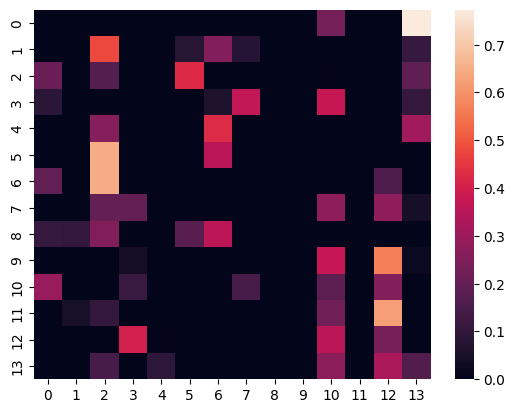

In [46]:
sns.heatmap(output.attentions[0][0, 0, :, :].detach().numpy())

In [5]:
query = model.encoder.layer[0].attention.self.query.weight
key = model.encoder.layer[0].attention.self.key.weight
value = model.encoder.layer[0].attention.self.value.weight

d_k = key.size(-1)

attention = ((query @ key.T) / (d_k**0.5)) @ value
# attention = torch.nn.functional.softmax(attention, )
# attention_probs = torch.nn.functional.softmax(scores, dim=-1)

In [6]:
attention = attention.detach().numpy()
attention.shape

(768, 768)

In [49]:
attention = output.attentions[0][0, 0, :, :].detach().numpy()
attention.shape

(14, 14)

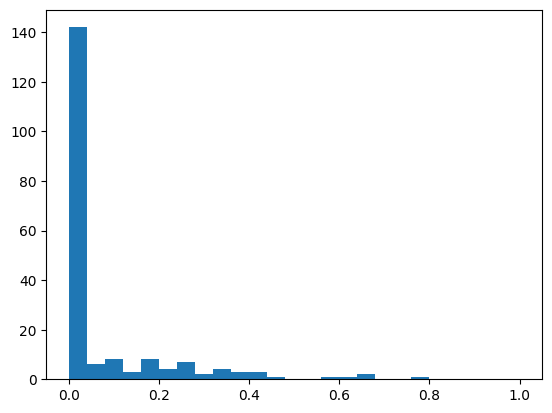

In [53]:
plt.hist(attention.flatten(), bins = 25, range = (0, 1))
plt.show()

In [8]:
threshold = 0.0045
A = np.where(attention > threshold, attention, 0)

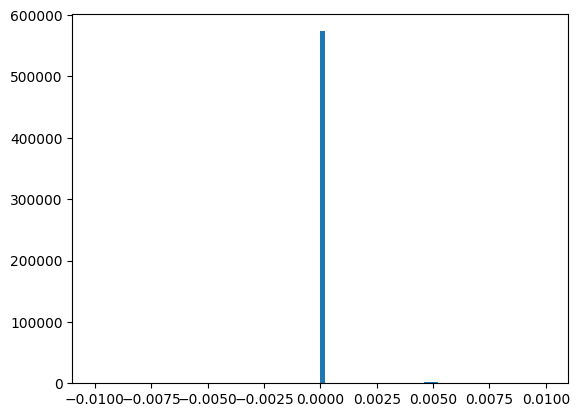

In [9]:
plt.hist(A.flatten(), bins = 100, range = (-0.01,0.01))
plt.show()

In [10]:
# A = np.array([[1,0,0],
#               [1,1,0],
#               [1,0,1],
#               [0,1,1]])

In [11]:
# A = np.array([[1,0,0,0],
#               [1,1,0,0],
#               [1,1,1,0],
#               [0,0,0,1]])

In [24]:
A = np.array([[1,0,0,0,0,0,0],
              [1,1,0,0,0,0,0],
              [1,1,1,0,0,0,0],
              [0,0,0,1,1,0,0],
              [0,0,0,0,1,1,0],
              [0,0,0,1,0,1,0]])

In [33]:
simp[1].shape[0] == 0

True

In [54]:
complex = SimplicialComplex()

NameError: name 'SimplicialComplex' is not defined

In [25]:
simp = []
for i in tqdm(range(A.shape[0])):
  simplex = np.nonzero(A[i])[0]
  if simplex.shape[0] != 0:
    simp.append(simplex)
    complex.add(simplex)

 33%|███▎      | 2/6 [00:00<00:00, 40.17it/s]


AttributeError: 'list' object has no attribute 'tolist'

In [37]:
len(simp)

692

In [31]:
attention.shape

(768, 768)

# simplicialx

In [60]:
import gtda.homology as gtdah

<Axes: >

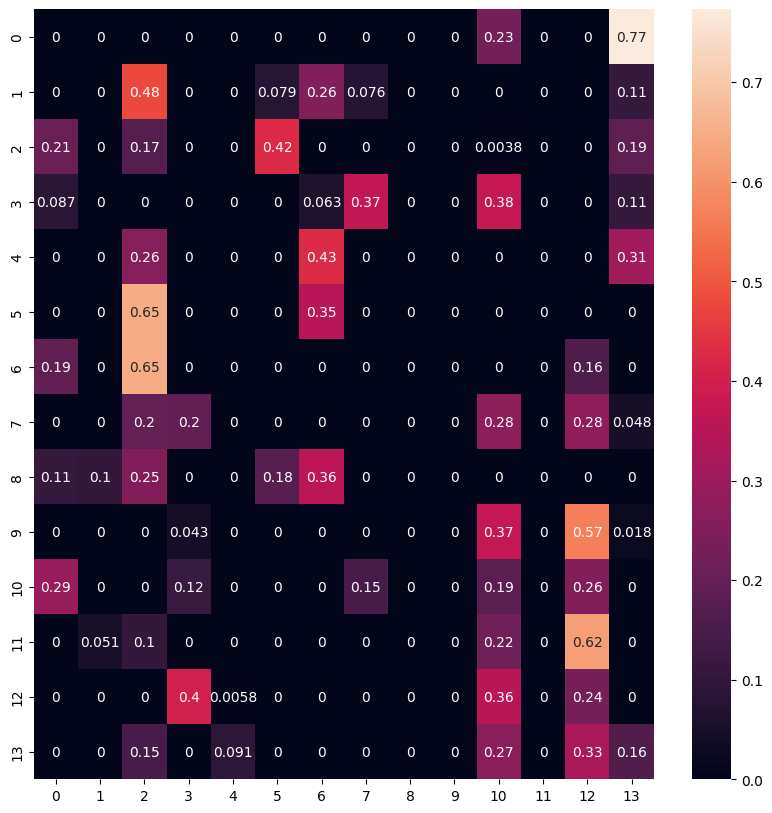

In [77]:
plt.figure(figsize=(10,10))
sns.heatmap(attention, annot=True)

In [80]:
flagser = gtdah.FlagserPersistence(
    homology_dimensions=(0, 1), directed=True, n_jobs=16, max_edge_weight=1, filtration="sum"
)

In [81]:
flagser.fit_transform_plot(attention[None, :, :])

RuntimeError: The data contains an edge filtration that contradicts the vertex filtration, the edge (0.000000, 2.000000) has filtration value 0.000000, which is lower than min(0.000000, 0.171192), the filtrations of its edges.

#другой

In [58]:
class pipelines:
  def __init__(self, A: np.array):
    self.A = A

  def forward(self, threshold: float):

    A = np.where(self.A > threshold, self.A, 0)

    simp = []
    for i in range(A.shape[0]):
      simp.append(np.nonzero(A[i])[0])

    st = gudhi.SimplexTree()
    for simplex in tqdm(simp):
        st.insert(simplex)

    st.compute_persistence()
    return st.betti_numbers()

In [59]:
pipeline = pipelines(attention)

pipeline.forward(0.01)

100%|██████████| 14/14 [00:00<00:00, 329.36it/s]


[1, 0, 2, 0]

#нексель

In [78]:
import generate_datasets
from generate_datasets import make_point_clouds

In [79]:
# from data.generate_datasets import make_point_clouds
n_samples_per_class = 10
point_clouds, labels = make_point_clouds(n_samples_per_class, 10, 0.1)
point_clouds.shape
print(f"There are {point_clouds.shape[0]} point clouds in {point_clouds.shape[2]} dimensions, "
      f"each with {point_clouds.shape[1]} points.")

There are 30 point clouds in 3 dimensions, each with 100 points.


In [ ]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text
diagrams = VR.fit_transform(point_clouds)
diagrams.shape

In [ ]:
point_clouds.shape

In [ ]:
from gtda.plotting import plot_diagram

i = 0
plot_diagram(diagrams[i])

In [ ]:
from gtda.diagrams import PersistenceEntropy

PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)

In [ ]:
from gtda.homology import FlagserPersistence as Flagser

In [ ]:
dense_matrix.shape

In [ ]:
import scipy.sparse
import networkx as nx
import matplotlib.pyplot as plt
from gtda.homology import FlagserPersistence as Flagser
from gtda.plotting import plot_diagram

# Создание графа с помощью NetworkX
G = nx.erdos_renyi_graph(n=40, p=0.05, seed=1)

# Визуализация графа
nx.draw(G, with_labels=True)
plt.show()

# Преобразование графа в симплициальный комплекс
flagser = Flagser()

# Преобразование графа в формат, принимаемый Flagser
adjacency_matrix = nx.adjacency_matrix(G)
flag_complex = flagser.fit_transform([adjacency_matrix])

# Визуализация диаграммы персистентности
plot_diagram(flag_complex[0])


In [ ]:
adjacency_matrix

In [ ]:
import scipy.sparse

dense_matrix = adjacency_matrix.toarray()

# Печать плотной матрицы
print("Плотная матрица:")
print(dense_matrix)

# Пример доступа к элементу
i, j = 1, 1
element = sparse_matrix[i, j]
print(f"Элемент в позиции ({i}, {j}): {element}")


In [ ]:
(dense_matrix == dense_matrix.T).sum()

In [ ]:
dense_matrix.T[0]

In [ ]:
A

In [ ]:
table.shape